# ISYE-6644 Project
### Monte Carlo Integration Techniques: Prepare a tutorial on Monte Carlo Integration Techniques and Give Several Examples
#### Utilize Monte Carlo Integration techniques on a different portfolios
Coding Portion for ISYE-6644 Simulation Project </p>
<strong> Author: Kha Tran </strong>

In [1]:
import warnings
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

<h3> PART 1 - Skeleton</h3>

Sample of Monte Carlo Integration with fixed parameters

In [2]:
#Fixed Parameters: 
stock_ticker = "SPY"
initial_price = 63.72
annual_return = 0.098 #(9.98% and 7.33% when adjusted for inflation)
volatility = 0.1189 #Average 30 years monthly volatility  
trading_days = 252 #Number of trading days
num_simulations = 1000 #Number of simulation 

def daily_returns_output(num_years): 
    
    total_days = trading_days * num_years
    daily_return = annual_return/trading_days
    daily_volatility = volatility/np.sqrt(trading_days)
    output = np.random.normal(daily_return, daily_volatility, (total_days, num_simulations))

    price_matrix = np.zeros((total_days, num_simulations))
    price_matrix[0, :] = initial_price
    
    return total_days, output, price_matrix

def simulation_plot(output, price_matrix, header): 
    for n in range(1, total_days): 
        price_matrix[n] = price_matrix[n-1] * (1 + output[n])
    
    plt.figure(figsize = (10, 6))
    plt.plot(price_matrix)
    plt.title(header)
    plt.xlabel("Trading Days")
    plt.ylabel("Price")
    plt.grid(True)
    return(plt.show())


def statistic_printout(price_matrix, num_years): 
    final_prices = price_matrix[-1, :]  #final_prices
    mean_price = np.mean(final_prices)
    median_price = np.median(final_prices)
    std = np.std(final_prices)
    confidence_interval = np.percentile(final_prices, [10, 90])


    #Annualized return (CAGR)
    cagr = (mean_price / initial_price) ** ( 1 / num_years ) - 1
    cagr = round(100 * cagr,2)
    print(f"The average final price is: {mean_price}")
    print(f"The median final price is: {median_price}")
    print(f"Standard Deviation: {std}")
    print(f"90% confidence interval: {confidence_interval}")
    print(f"Compound annual growth rate is: {cagr}%")
    
    plt.hist(final_prices, bins=50, alpha=0.85)
    plt.title('Distribution of Final Prices')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    return(plt.show())

<h5> Time Frame : 1 Year </h5>

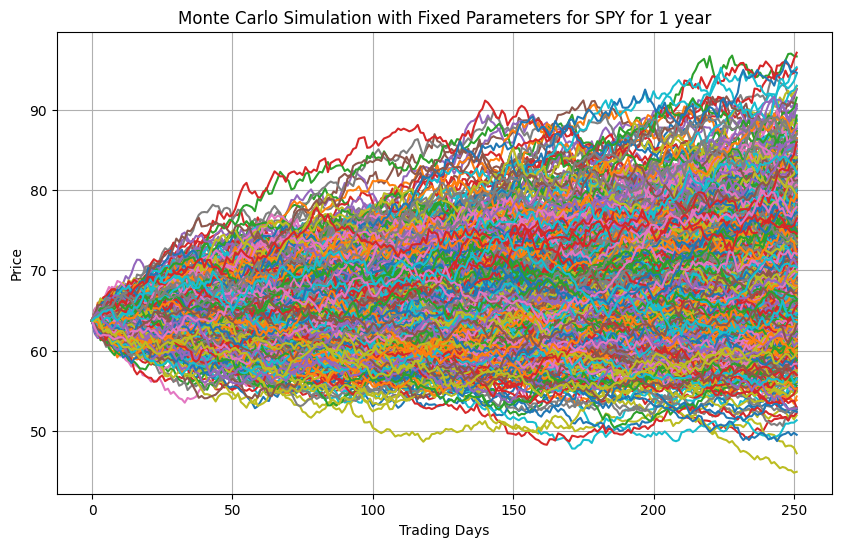

The average final price is: 70.09720230079526
The median final price is: 69.74348124805147
Standard Deviation: 8.410271716008376
90% confidence interval: [59.44366138 81.21771281]
Compound annual growth rate is: 10.01%


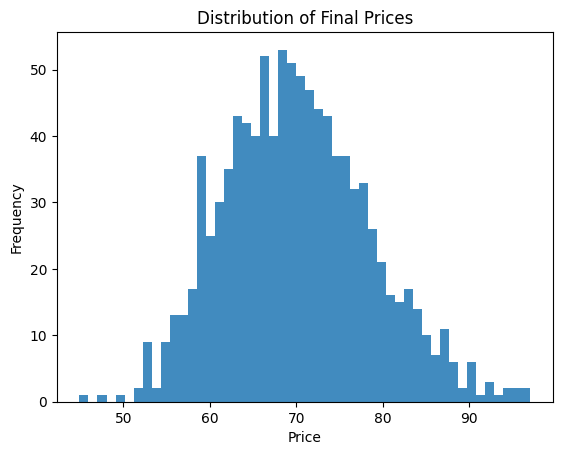

In [3]:
num_years = 1
total_days, output, price_matrix = daily_returns_output(num_years)

simulation_plot(output, price_matrix, "Monte Carlo Simulation with Fixed Parameters for SPY for 1 year")

statistic_printout(price_matrix, num_years)

<h5> Time Frame: 30 years </h5>

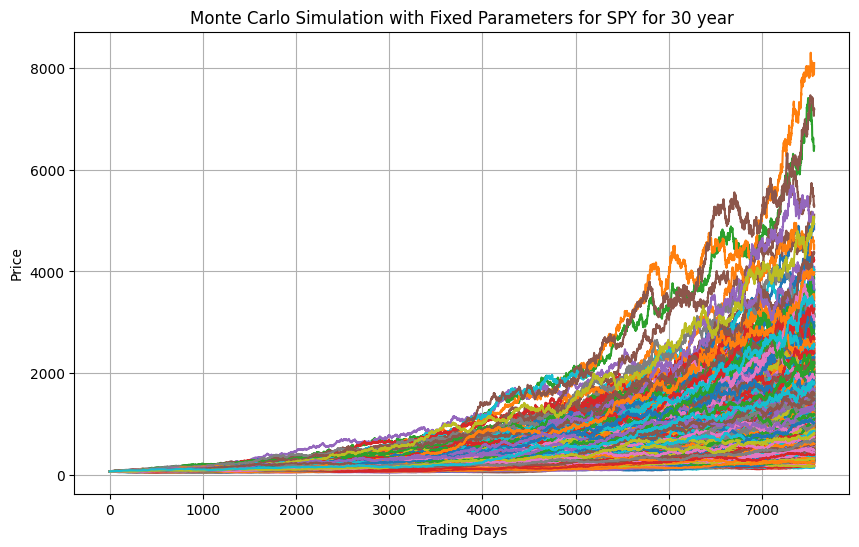

The average final price is: 1213.8797862794418
The median final price is: 1002.242949723252
Standard Deviation: 854.6464800133637
90% confidence interval: [ 443.51112583 2222.76786376]
Compound annual growth rate is: 10.32%


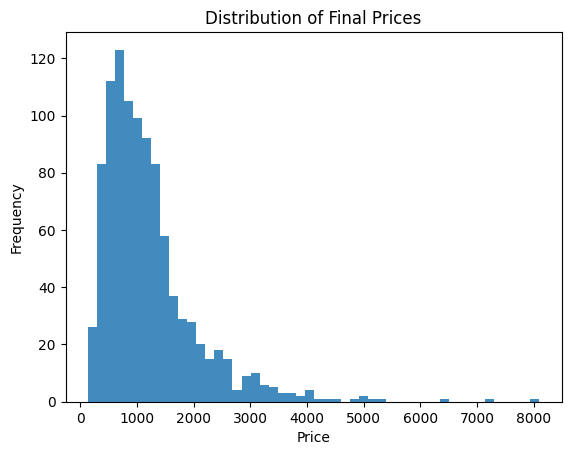

In [4]:
num_years = 30
total_days, output, price_matrix = daily_returns_output(30)

simulation_plot(output, price_matrix, "Monte Carlo Simulation with Fixed Parameters for SPY for 30 year")
statistic_printout(price_matrix, num_years)

<h3> Part II: API, Simulation, and Statistic </h3>

In [5]:
#To collect and record individual stock data
#To build your portfolio 
class Monte_Carlo_Simulation: 

    def __init__(self, num_years, initial_investment, 
                 custom_allocation = False, tickers = None, tickers_with_allocation = None): 
        #Set custom_allocation = True to allow for custom allocation, else it will equally distributed

        #Stock tickers with allocation
        self.tickers = tickers #List of stocks
        self.tickers_with_allocation = tickers_with_allocation #dictionary of stock and its distribution
        self.tickers_daily_return = None #List of historical daily returns
        self.custom_allocation = custom_allocation

        
        self.tickers_param = {} #Parameters for each ticker, drift and volatility 
        
        #num_years 
        self.total_days = num_years * 252
        
        self.initial_investment = initial_investment
        
        #Closing price dictionary to buy with the initial investment
        self.closing_prices = {}  #Closing price dictionary to buy with the initial investment
        self.my_portfolio = {
            'Ticker' :[],
            'Shares' :[],
            'Purchase Price':[],
            'Value':[],
            'Beta': []
        }
       
        self.historical_prices = self.historical_daily_return()
    #API pulling closing price data
    def historical_daily_return(self): 
        temp_list = []
        if self.custom_allocation == True: 
            self.tickers = list(self.tickers_with_allocation.keys())

        #print(self.tickers)
        for ticker in self.tickers: 
            ticker_data = yf.Ticker(ticker)

            #Closing price
            closing_price = ticker_data.history(period = 'max')['Close']
            self.closing_prices[ticker] = closing_price[-1]
            #Daily return
            daily_change = closing_price.pct_change().dropna()
            #print(daily_change)
            #parameters, drift + volatility 
            average_daily_change = round(np.mean(daily_change),8) #average daily return or the mean
            daily_volatility = round(np.std(daily_change, ddof = 1),4)

            #add to the dictionary
            self.tickers_param[ticker] = {"average_daily_change": average_daily_change,
                                          "daily_volatility": daily_volatility}
            
            
            #Add to a new dataframe. This will add multiple ticker's data to the same dataframe
            temp_df = closing_price.to_frame(name = ticker)
            if not temp_df.dropna().empty:  
                temp_list.append(temp_df)
            else: 
                print(f'Data for {ticker} is entirely NaN and will be excluded.')
            
        self.tickers_daily_return = pd.concat(temp_list, axis = 1)

    #Store portfolio values, shares purchases with equal amount
    def portfolio(self): 

        for ticker, price in self.closing_prices.items():
            if self.custom_allocation == False: 
                allocation_percentage = 1/ (len(self.closing_prices))
            elif self.custom_allocation == True: 
                allocation_percentage = self.tickers_with_allocation[ticker]


            ticker_data = yf.Ticker(ticker)
            try: 
                beta = ticker_data.info['beta']
            except:
                beta = 1

            
            position_amount = self.initial_investment * allocation_percentage
            shares_to_buy = position_amount/price
            self.my_portfolio['Ticker'].append(ticker)
            self.my_portfolio['Shares'].append(round(shares_to_buy,2))
            self.my_portfolio['Purchase Price'].append(round(price,2))
            self.my_portfolio['Value'].append(position_amount)
            self.my_portfolio['Beta'].append(beta)
        
        portfolio_df = pd.DataFrame(self.my_portfolio)
        #print(portfolio_df)
        return(portfolio_df)

    def monte_carlo_portfolio(self, portfolio_df, num_simulation = 1000): 
        days = self.total_days
        
        daily_changes_list = []
        daily_volatilities_list = []

        
        for stock, values in self.tickers_param.items(): 
            daily_changes_list.append(values['average_daily_change'])
            daily_volatilities_list.append(values['daily_volatility'])

        daily_changes_array = np.array(daily_changes_list)
        daily_volatilities_array = np.array(daily_volatilities_list)

        #print("Daily Changes Array:", daily_changes_array)
        #print("Daily Volatilities Array:", daily_volatilities_array)
        #print("Expected number of tickers:", len(self.tickers))
        #print("Number of parameters fetched:", len(daily_changes_array))
        #Initial a resulting dataframe: 
        output = np.zeros((days, num_simulation))

        for n in range(num_simulation): 
            simulated_values = portfolio_df['Shares'] * portfolio_df['Purchase Price']

            for day in range(days): 
                 # Calculate daily price changes
                daily_price_changes = 1 + np.random.normal(daily_changes_array, daily_volatilities_array)
                simulated_values *= daily_price_changes
            
                # Store the total portfolio value at the end of each day
                output[day, n] = simulated_values.sum()

        return output

In [6]:
class plot_and_stat: 
    def __init__(self, price_matrix, header, num_years, initial_investment): 
        self.price_matrix = price_matrix
        self.header = header
        self.num_years = num_years
        self.initial_investment = initial_investment
    
    def simulation_plot(self): 
        plt.figure(figsize = (10, 6))
        plt.plot(self.price_matrix)
        plt.title(self.header)
        plt.xlabel("Trading Days")
        plt.ylabel("Price")
        plt.grid(True)
        plt.show()

    def statistic_printout(self): 
        final_prices = self.price_matrix[-1, :]  #final_prices
        #print(final_prices)
        mean_price = round(np.mean(final_prices),4)
        median_price = round(np.median(final_prices),4)
        std = round(np.std(final_prices),4)
        confidence_interval = np.percentile(np.round(final_prices,4), [2.5, 97.5])
        lower_bound, upper_bound = confidence_interval
    
        #Annualized return (CAGR)
        cagr = ((mean_price / self.initial_investment) ** ( 1 / self.num_years )) - 1
        cagr = round(100 * cagr,2)

        #Printout
        print(f"The average final price is: {mean_price}")
        print(f"The median final price is: {median_price}")
        print(f"Standard Deviation: {std}")
        print(f"95% confidence interval: {confidence_interval}")
        print(f"Compound annual growth rate is: {cagr}%")
        
        plt.hist(final_prices, bins=50, alpha=0.85)
        plt.title('Distribution of Final Prices')
        plt.xlabel('Price')
        plt.ylabel('Frequency')
        plt.show()

In [7]:
#Helper function to rerun this simulation for different scenarios
def simulation_run(num_years, initial_investment, tickers, header, custom_allocation = False): 

    if custom_allocation == True: 
        _portfolio = Monte_Carlo_Simulation(num_years = num_years, initial_investment = initial_investment, 
                                            tickers_with_allocation = tickers, custom_allocation = custom_allocation)
    else: 
        _portfolio = Monte_Carlo_Simulation(num_years = num_years, initial_investment = initial_investment, 
                                            tickers = tickers,  custom_allocation = custom_allocation)
    
    _portfolio_df = _portfolio.portfolio()
    
    price_matrix = _portfolio.monte_carlo_portfolio(_portfolio_df)
               
    plot_ = plot_and_stat(price_matrix, header, num_years, initial_investment)
    plot_.simulation_plot()
    plot_.statistic_printout()

    beta = _portfolio_df['Beta'].mean()
    beta = round(beta, 4)
    print(f"Portfolio's beta: {beta}")
    return _portfolio_df

<h5> Warren Buffet Portfolio </h5>

<h5> Equal allocation - 1 year </h5>

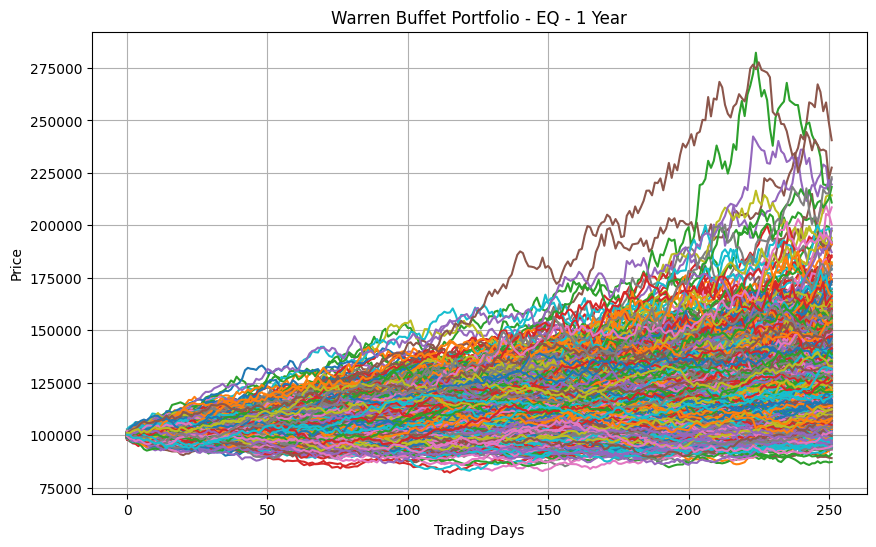

The average final price is: 127728.9439
The median final price is: 123753.4309
Standard Deviation: 21604.1776
95% confidence interval: [ 96282.5700525 181122.412175 ]
Compound annual growth rate is: 27.73%


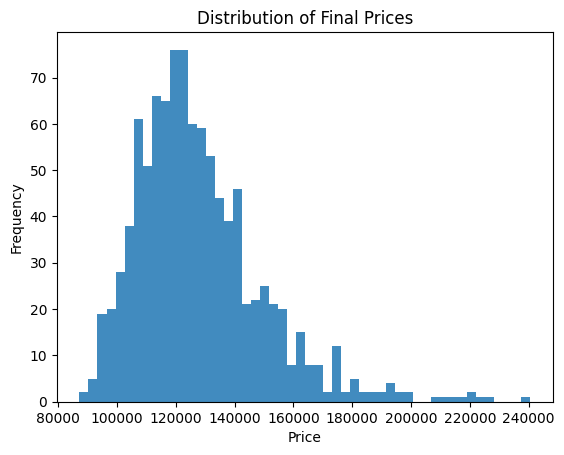

Portfolio's beta: 1.0659


,Ticker,Shares,Purchase Price,Value,Beta
0,AAPL,60.30,165.84,10000.0,1.276
1,BAC,265.04,37.73,10000.0,1.388
2,AXP,42.92,233.00,10000.0,1.227
3,KO,165.15,60.55,10000.0,0.586
4,CVX,61.76,161.92,10000.0,1.129
5,OXY,149.25,67.00,10000.0,1.687
6,KHC,262.12,38.15,10000.0,0.672
7,MCO,26.37,379.26,10000.0,1.261
8,MTSUY,439.37,22.76,10000.0,0.639
9,MITSY,10.53,949.77,10000.0,0.794


In [8]:
#Top 10 Warren Buffet Portfolio
tickers = ['AAPL', 'BAC', 'AXP', 'KO', 'CVX', 'OXY', 'KHC', 'MCO', 'MTSUY', 'MITSY']
custom_allocation = False
initial_investment = 100000
num_years = 1
header = "Warren Buffet Portfolio - EQ - 1 Year" 

simulation_run(num_years = num_years, initial_investment = initial_investment, tickers = tickers, 
               header = header, custom_allocation = custom_allocation)

<h5> Equal allocation - 5 years </h5>

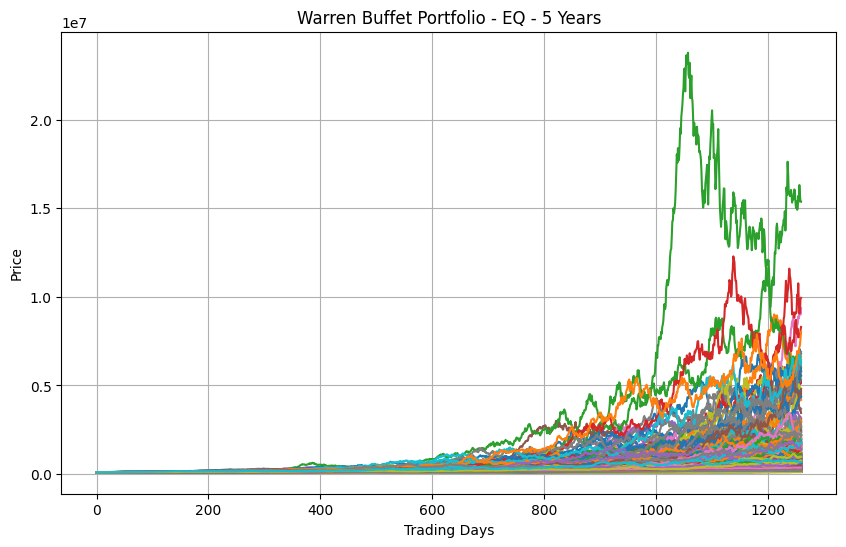

The average final price is: 717693.6708
The median final price is: 383659.2188
Standard Deviation: 1109379.749
95% confidence interval: [ 148965.188705   3451823.68049999]
Compound annual growth rate is: 48.32%


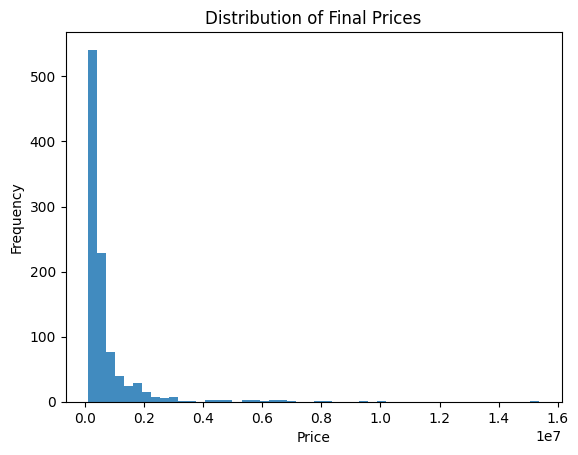

Portfolio's beta: 1.0659


,Ticker,Shares,Purchase Price,Value,Beta
0,AAPL,60.30,165.84,10000.0,1.276
1,BAC,265.04,37.73,10000.0,1.388
2,AXP,42.92,233.00,10000.0,1.227
3,KO,165.15,60.55,10000.0,0.586
4,CVX,61.76,161.92,10000.0,1.129
5,OXY,149.25,67.00,10000.0,1.687
6,KHC,262.12,38.15,10000.0,0.672
7,MCO,26.37,379.26,10000.0,1.261
8,MTSUY,439.37,22.76,10000.0,0.639
9,MITSY,10.53,949.77,10000.0,0.794


In [9]:
#Top 10 Warren Buffet Portfolio
tickers = ['AAPL', 'BAC', 'AXP', 'KO', 'CVX', 'OXY', 'KHC', 'MCO', 'MTSUY', 'MITSY']
custom_allocation = False
initial_investment = 100000
num_years = 5
header = "Warren Buffet Portfolio - EQ - 5 Years" 

simulation_run(num_years = num_years, initial_investment = initial_investment, tickers = tickers, 
               header = header, custom_allocation = custom_allocation)

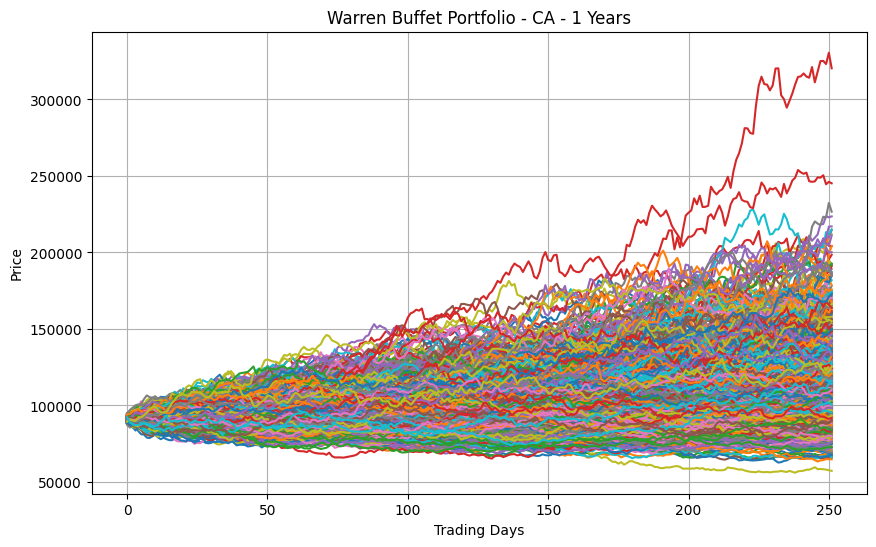

The average final price is: 113870.9827
The median final price is: 110013.665
Standard Deviation: 27507.7487
95% confidence interval: [ 75831.879105  185728.5372525]
Compound annual growth rate is: 13.87%


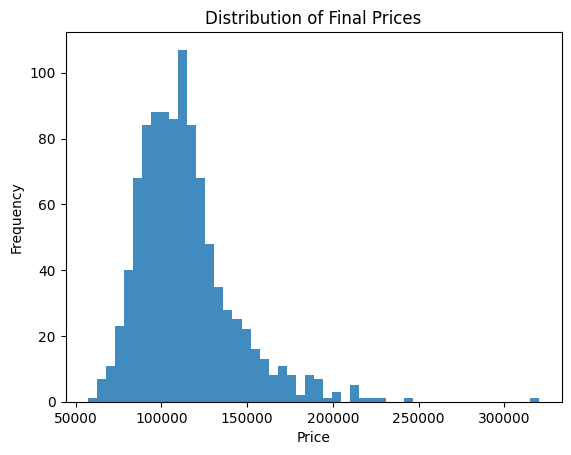

Portfolio's beta: 1.0659


,Ticker,Shares,Purchase Price,Value,Beta
0,AAPL,249.64,165.84,41400.0,1.276
1,BAC,275.64,37.73,10400.0,1.388
2,AXP,39.91,233.00,9300.0,1.227
3,KO,153.59,60.55,9300.0,0.586
4,CVX,40.14,161.92,6500.0,1.129
5,OXY,67.16,67.00,4500.0,1.687
6,KHC,86.50,38.15,3300.0,0.672
7,MCO,6.86,379.26,2600.0,1.261
8,MTSUY,96.66,22.76,2200.0,0.639
9,MITSY,1.68,949.77,1600.0,0.794


In [10]:
#Top 10 Warren Buffet's portfolio
tickers = {'AAPL': .414, 'BAC': .104, 'AXP': 0.093, 'KO': 0.093, 'CVX': 0.065, 
                 'OXY': 0.045, 'KHC': 0.033, 'MCO': 0.026, 'MTSUY': 0.022, 'MITSY': 0.016}
custom_allocation = True
initial_investment = 100000
num_years = 1
header = "Warren Buffet Portfolio - CA - 1 Years" 

simulation_run(num_years = num_years, initial_investment = initial_investment, tickers = tickers, 
               header = header, custom_allocation = custom_allocation)

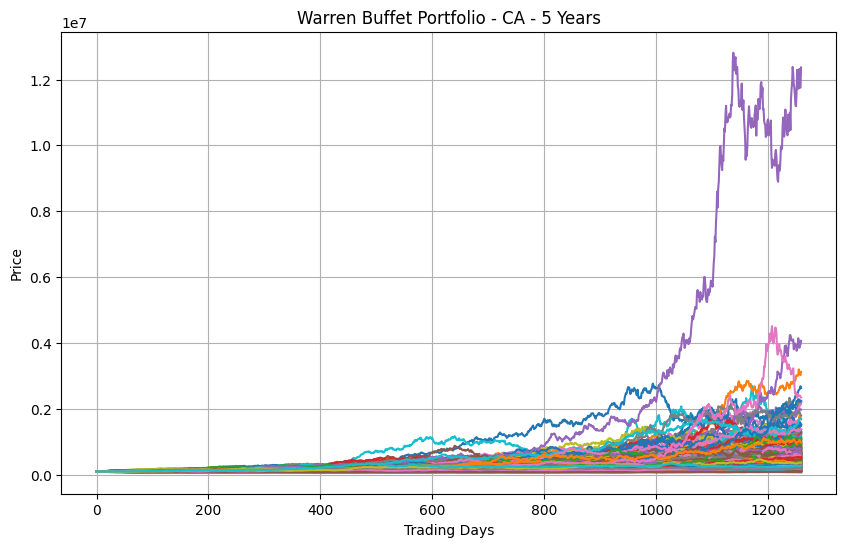

The average final price is: 386946.1448
The median final price is: 278454.4591
Standard Deviation: 501333.4323
95% confidence interval: [ 111792.5843275 1252844.4580075]
Compound annual growth rate is: 31.08%


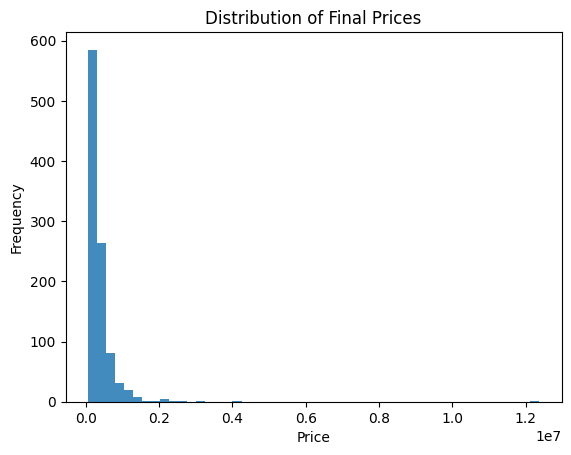

Portfolio's beta: 1.0659


,Ticker,Shares,Purchase Price,Value,Beta
0,AAPL,249.64,165.84,41400.0,1.276
1,BAC,275.64,37.73,10400.0,1.388
2,AXP,39.91,233.00,9300.0,1.227
3,KO,153.59,60.55,9300.0,0.586
4,CVX,40.14,161.92,6500.0,1.129
5,OXY,67.16,67.00,4500.0,1.687
6,KHC,86.50,38.15,3300.0,0.672
7,MCO,6.86,379.26,2600.0,1.261
8,MTSUY,96.66,22.76,2200.0,0.639
9,MITSY,1.68,949.77,1600.0,0.794


In [11]:
tickers = {'AAPL': .414, 'BAC': .104, 'AXP': 0.093, 'KO': 0.093, 'CVX': 0.065, 
                 'OXY': 0.045, 'KHC': 0.033, 'MCO': 0.026, 'MTSUY': 0.022, 'MITSY': 0.016}
custom_allocation = True
initial_investment = 100000
num_years = 5
header = "Warren Buffet Portfolio - CA - 5 Years" 

simulation_run(num_years = num_years, initial_investment = initial_investment, tickers = tickers, 
               header = header, custom_allocation = custom_allocation)

<h4> Top 20 SPY Holding </h4>

In [12]:
df = pd.read_csv("./SPY_STOCKS.csv")
df.sort_values(by="Portfolio Weight", ascending = False, inplace = True)
top_20 = df.head(20)
top_20

,Symbol,Description,Portfolio Weight,Shares Held,Market Value
0,MSFT,Microsoft Corp,7.24%,88.0M,$36.3B
1,AAPL,Apple Inc,5.77%,172.0M,$28.9B
2,NVDA,NVIDIA Corp,4.91%,29.3M,$24.6B
3,AMZN,Amazon.com Inc,3.92%,108.3M,$19.6B
4,META,Meta Platforms Inc Class A,2.57%,26.1M,$12.9B
5,GOOGL,Alphabet Inc Class A,2.17%,69.8M,$10.9B
6,LLY,Eli Lilly and Co,1.42%,9.4M,$7.1B
7,AVGO,Broadcom Inc,1.34%,5.2M,$6.7B
8,JPM,JPMorgan Chase & Co,1.23%,34.2M,$6.2B
9,XOM,Exxon Mobil Corp,1.11%,47.0M,$5.6B


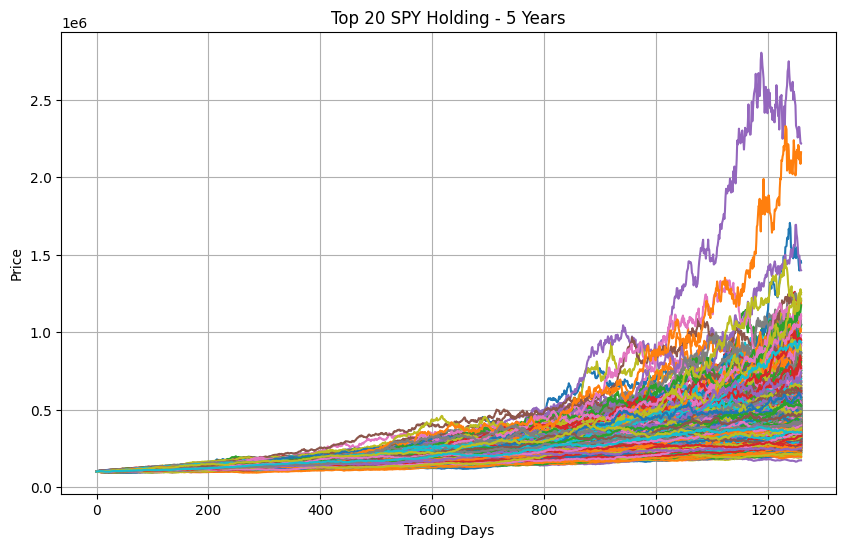

The average final price is: 443868.6709
The median final price is: 399595.0713
Standard Deviation: 183871.6236
95% confidence interval: [241155.0043425 934790.212365 ]
Compound annual growth rate is: 34.73%


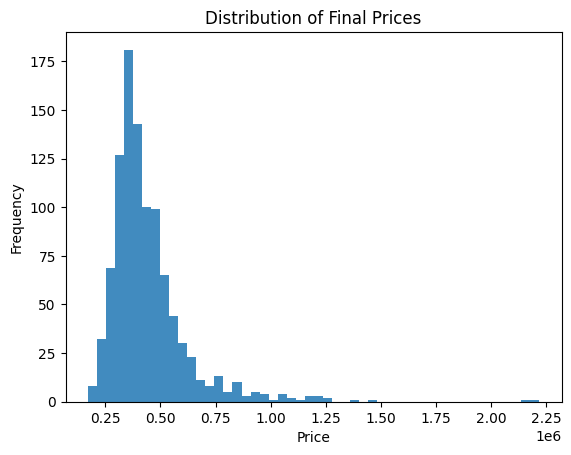

Portfolio's beta: 0.9847


,Ticker,Shares,Purchase Price,Value,Beta
0,MSFT,12.47,400.96,5000.0,0.877
1,AAPL,30.15,165.84,5000.0,1.276
2,NVDA,6.29,795.18,5000.0,1.744
3,AMZN,28.21,177.23,5000.0,1.160
4,META,10.38,481.73,5000.0,1.184
5,GOOGL,31.99,156.28,5000.0,1.054
6,LLY,6.84,731.33,5000.0,0.367
7,AVGO,4.08,1224.46,5000.0,1.268
8,JPM,26.40,189.41,5000.0,1.117
9,XOM,41.47,120.56,5000.0,0.964


In [13]:
#Top 20 Holding SPY by weighted
tickers = list(top_20['Symbol'])
custom_allocation = False
initial_investment = 100000
num_years = 5
header = "Top 20 SPY Holding - 5 Years" 

simulation_run(num_years = num_years, initial_investment = initial_investment, tickers = tickers, 
               header = header, custom_allocation = custom_allocation)

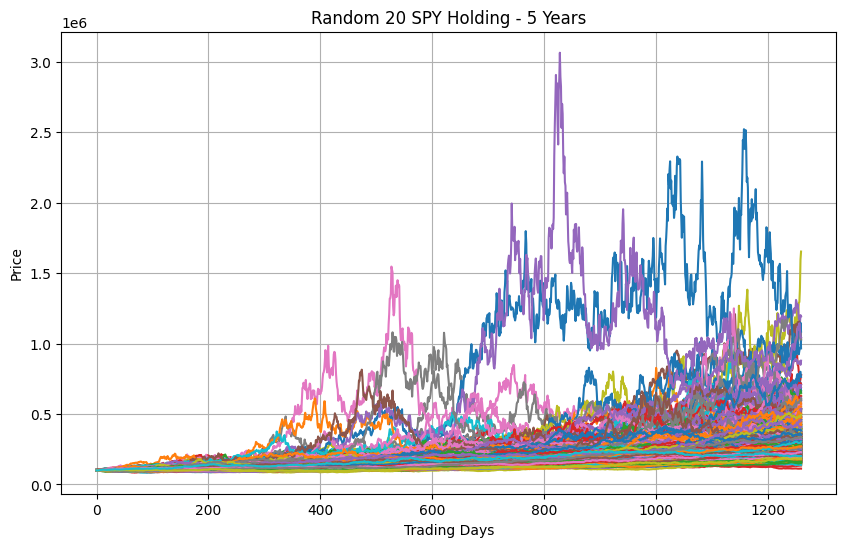

The average final price is: 283939.2966
The median final price is: 257949.2671
Standard Deviation: 123159.5105
95% confidence interval: [159861.6649225 592992.72217  ]
Compound annual growth rate is: 23.21%


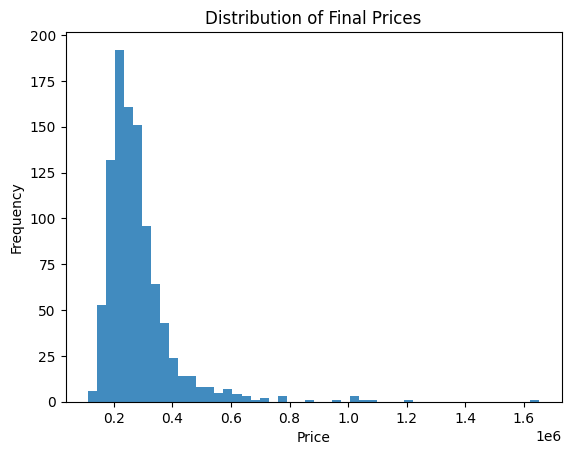

Portfolio's beta: 1.1014


,Ticker,Shares,Purchase Price,Value,Beta
0,BDX,21.38,233.88,5000.0,0.458
1,EBAY,98.15,50.94,5000.0,1.324
2,ALLE,39.87,125.42,5000.0,1.134
3,TSN,82.49,60.61,5000.0,0.754
4,BR,25.74,194.23,5000.0,0.982
5,CDNS,17.54,285.02,5000.0,1.032
6,TFX,24.12,207.27,5000.0,1.118
7,REG,84.45,59.21,5000.0,1.179
8,FFIV,27.85,179.55,5000.0,1.113
9,HUBB,12.80,390.56,5000.0,0.934


In [14]:
#Randomly choosen 20 stocks from SPY
tickers = list(df['Symbol'].sample(n = 20))
initial_investment = 100000
num_years = 5
header = "Random 20 SPY Holding - 5 Years" 

simulation_run(num_years = num_years, initial_investment = initial_investment, tickers = tickers, 
               header = header, custom_allocation = custom_allocation)

<h5> Nasdaq (Technology focus) - Random 20</h5>

In [15]:
NASDAQ = pd.read_csv("./NASDAQ_STOCKS.csv")
NASDAQ.head()

,No.,Symbol,Company Name,Market Cap,Stock Price,% Change,Revenue
0,1,MSFT,Microsoft Corporation,2984659139200,401.74,0.66%,2.275830e+11
1,2,AAPL,Apple Inc,2573315425500,166.66,1.01%,3.857060e+11
2,3,NVDA,NVIDIA Corporation,1995175250000,799.12,4.87%,6.092200e+10
3,4,GOOGL,Alphabet Inc.,1960274911208,156.94,1.85%,3.073940e+11
4,5,GOOG,Alphabet Inc.,1959040783285,158.49,1.78%,3.073940e+11


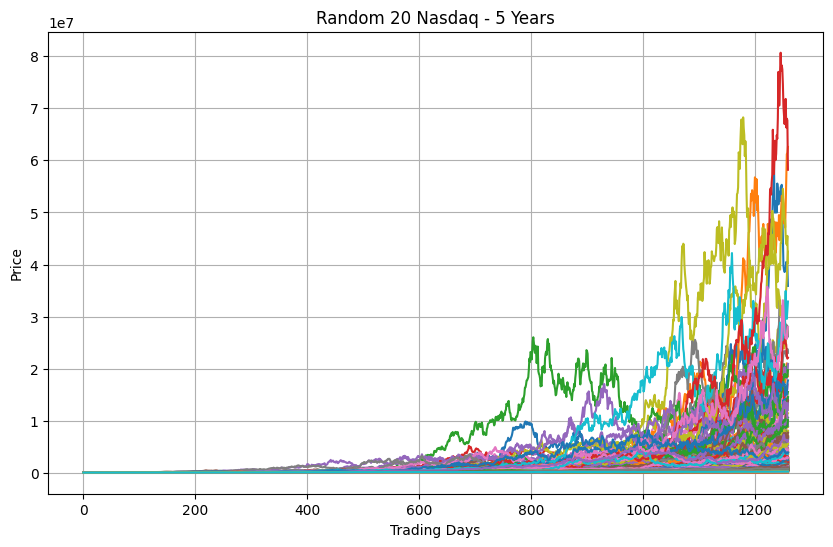

The average final price is: 1602059.1484
The median final price is: 507453.8518
Standard Deviation: 4548147.6241
95% confidence interval: [  216203.8118925  11541402.26856246]
Compound annual growth rate is: 74.15%


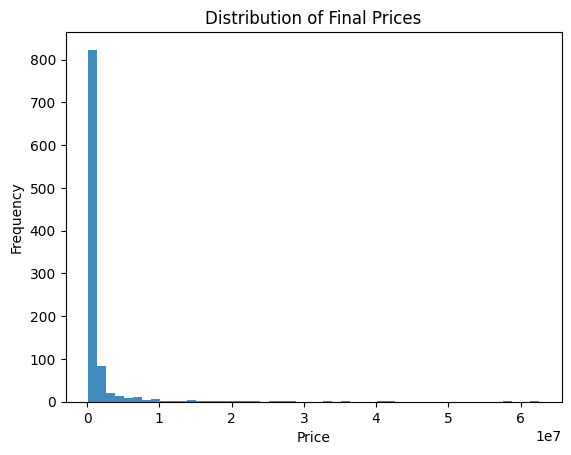

Portfolio's beta: 1.0477


,Ticker,Shares,Purchase Price,Value,Beta
0,APLS,104.95,47.64,5000.0,0.888
1,MAR,21.06,237.41,5000.0,1.620
2,ALAB,76.00,65.79,5000.0,1.000
3,HLNE,44.85,111.48,5000.0,1.176
4,RYAAY,35.52,140.78,5000.0,1.526
5,UTHR,21.36,234.06,5000.0,0.550
6,ALKS,207.73,24.07,5000.0,0.554
7,LAMR,43.97,113.71,5000.0,1.523
8,ULTA,11.96,417.98,5000.0,1.306
9,ERIE,13.08,382.21,5000.0,0.412


In [16]:
tickers = list(NASDAQ ['Symbol'].sample(n = 20))
custom_allocation = False
initial_investment = 100000
num_years = 5
header = "Random 20 Nasdaq - 5 Years" 

simulation_run(num_years = num_years, initial_investment = initial_investment, tickers = tickers, 
               header = header, custom_allocation = custom_allocation)

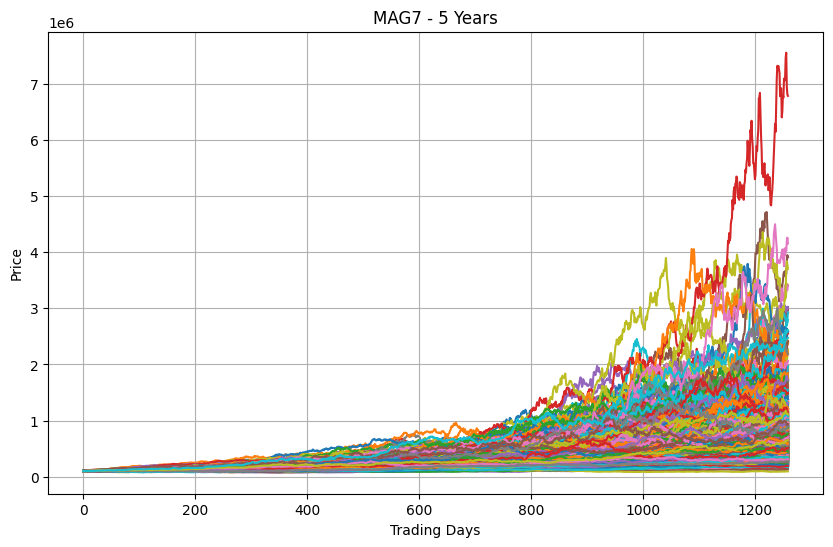

The average final price is: 688246.5934
The median final price is: 545402.4358
Standard Deviation: 524014.4041
95% confidence interval: [ 205410.3244575 2068729.938125 ]
Compound annual growth rate is: 47.08%


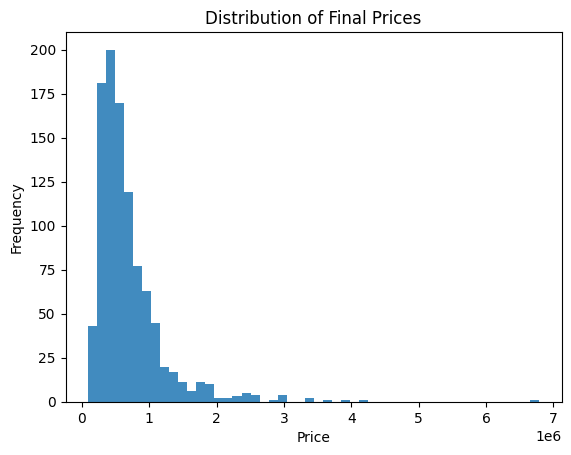

Portfolio's beta: 1.3909


,Ticker,Shares,Purchase Price,Value,Beta
0,MSFT,35.63,400.96,14285.714286,0.877
1,AAPL,86.14,165.84,14285.714286,1.276
2,NVDA,17.97,795.18,14285.714286,1.744
3,AMZN,80.61,177.23,14285.714286,1.160
4,META,29.66,481.73,14285.714286,1.184
5,GOOGL,91.41,156.28,14285.714286,1.054
6,TSLA,100.57,142.05,14285.714286,2.441


In [20]:
#High Beta portfolio
tickers = ["MSFT", "AAPL", "NVDA", "AMZN", "META", "GOOGL","TSLA"]
custom_allocation = False
initial_investment = 100000
num_years = 5
header = "MAG7 - 5 Years" 

simulation_run(num_years = num_years, initial_investment = initial_investment, tickers = tickers, 
               header = header, custom_allocation = custom_allocation)

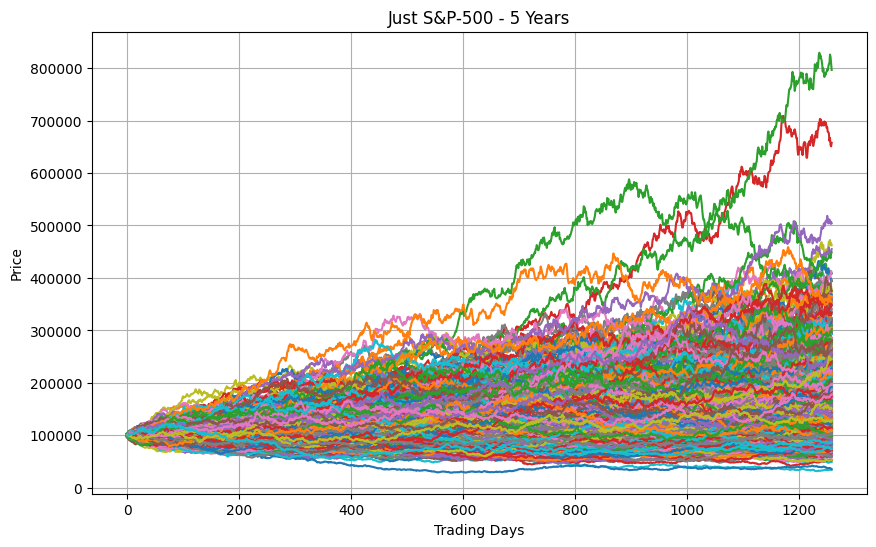

The average final price is: 173437.3389
The median final price is: 159190.0994
Standard Deviation: 76141.352
95% confidence interval: [ 69639.4455075 358140.6858075]
Compound annual growth rate is: 11.64%


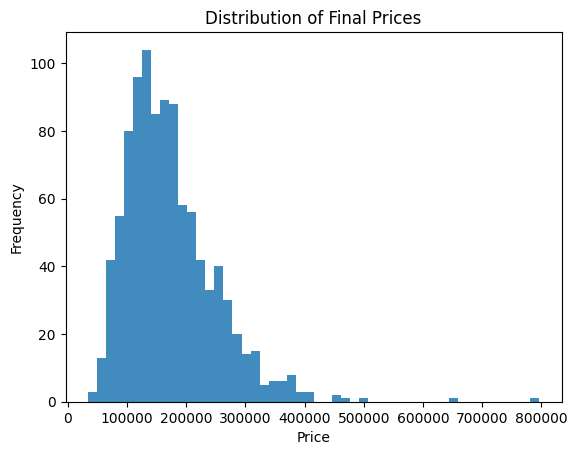

Portfolio's beta: 1.0


,Ticker,Shares,Purchase Price,Value,Beta
0,SPY,200.11,499.72,100000.0,1


In [18]:
#SPY portfolio
tickers = ['SPY']
custom_allocation = False
initial_investment = 100000
num_years = 5
header = "Just S&P-500 - 5 Years" 

simulation_run(num_years = num_years, initial_investment = initial_investment, tickers = tickers, 
               header = header, custom_allocation = custom_allocation)